In [1]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [3]:
%cd /content/drive/MyDrive/
!ls

/content/drive/MyDrive
'Colab Notebooks'   Mask_RCNN	        Mask-RCNN-TF2	    OLD_Mask_RCNN
 data		    mask_rcnn_coco.h5   Mask-RCNN-TF2.zip   requirements.txt


In [ ]:
!pip install -r '/content/drive/MyDrive/Mask-RCNN-TF2/requirements.txt'

In [5]:
import tensorflow as tf
print(tf.__version__)

2.0.0


In [6]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 8247516005271752608
, name: "/device:XLA_CPU:0"
device_type: "XLA_CPU"
memory_limit: 17179869184
locality {
}
incarnation: 15286581135514057560
physical_device_desc: "device: XLA_CPU device"
]


In [41]:
import os
import sys
import itertools
import math
import logging
import json
import re
import random
from collections import OrderedDict
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.lines as lines
from matplotlib.patches import Polygon

# Root directory of the project
ROOT_DIR = os.path.abspath("/content/drive/MyDrive/Mask-RCNN-TF2")

# Import Mask RCNN
sys.path.append(ROOT_DIR)  # To find local version of the library
from mrcnn import utils
from mrcnn import visualize
from mrcnn.visualize import display_images
import mrcnn.model as modellib
from mrcnn.model import log

# from samples.balloon import balloon
# from mrcnn import balloon
from mrcnn import footer

%matplotlib inline 

In [42]:
config = footer.Footer_detectorConfig()
FOOTER_DIR = os.path.join(ROOT_DIR, "datasets/footer")

In [43]:
# Load dataset
# Get the dataset from the releases page
# https://github.com/matterport/Mask_RCNN/releases
dataset = footer.Footer_detectorDataset()
dataset.load_footer_detector(FOOTER_DIR, "train")

# Must call before using the dataset
dataset.prepare()

print("Image Count: {}".format(len(dataset.image_ids)))
print("Class Count: {}".format(dataset.num_classes))
for i, info in enumerate(dataset.class_info):
    print("{:3}. {:50}".format(i, info['name']))

manual annotation class count: 7
annotations count:	239
Image Count: 239
Class Count: 8
  0. BG                                                
  1. input                                             
  2. button                                            
  3. text                                              
  4. select                                            
  5. checkbox                                          
  6. radiobutton                                       
  7. image                                             


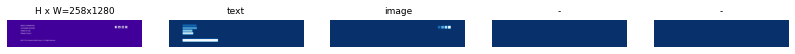

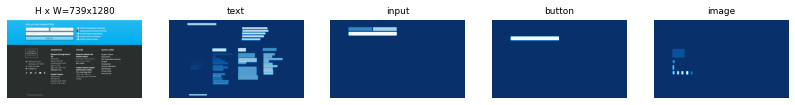

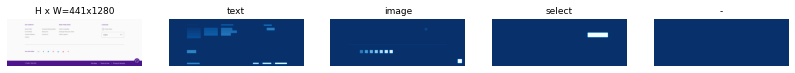

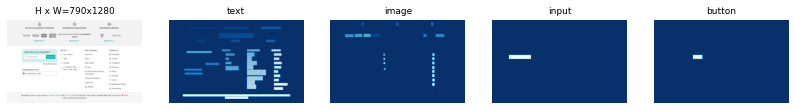

In [44]:
# Load and display random samples
image_ids = np.random.choice(dataset.image_ids, 4)
for image_id in image_ids:
    image = dataset.load_image(image_id)
    mask, class_ids = dataset.load_mask(image_id)
    visualize.display_top_masks(image, mask, class_ids, dataset.class_names)

image_id  187 /content/drive/MyDrive/Mask-RCNN-TF2/datasets/footer/train/4204_quotenet_nl_203.png
image                    shape: (558, 1280, 3)        min:   14.00000  max:  127.00000  uint8
mask                     shape: (558, 1280, 19)       min:    0.00000  max:    1.00000  bool
class_ids                shape: (19,)                 min:    3.00000  max:    7.00000  int32
bbox                     shape: (19, 4)               min:   30.00000  max: 1032.00000  int32


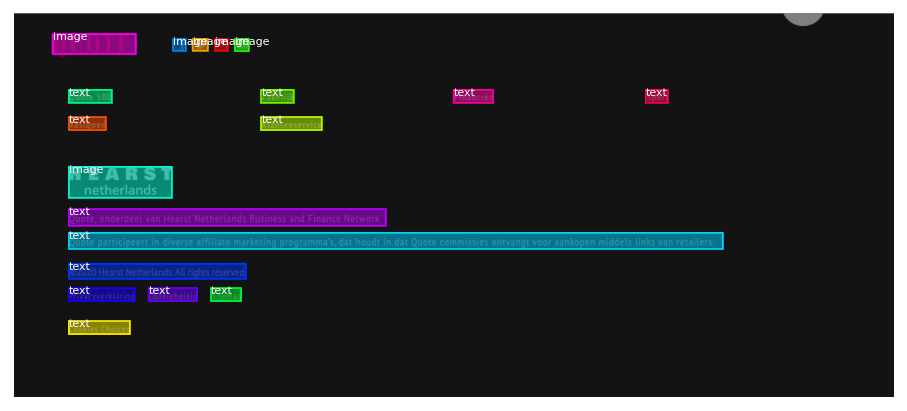

In [45]:
# Load random image and mask.
image_id = random.choice(dataset.image_ids)
image = dataset.load_image(image_id)
mask, class_ids = dataset.load_mask(image_id)
# Compute Bounding box
bbox = utils.extract_bboxes(mask)

# Display image and additional stats
print("image_id ", image_id, dataset.image_reference(image_id))
log("image", image)
log("mask", mask)
log("class_ids", class_ids)
log("bbox", bbox)
# Display image and instances
visualize.display_instances(image, bbox, mask, class_ids, dataset.class_names)

image_id:  27 /content/drive/MyDrive/Mask-RCNN-TF2/datasets/footer/train/4031_home_howstuffworks_com_30.png
Original shape:  (290, 1280, 3)
image                    shape: (1024, 1024, 3)       min:    0.00000  max:  153.00000  uint8
mask                     shape: (1024, 1024, 17)      min:    0.00000  max:    1.00000  bool
class_ids                shape: (17,)                 min:    2.00000  max:    7.00000  int32
bbox                     shape: (17, 4)               min:   48.00000  max:  975.00000  int32


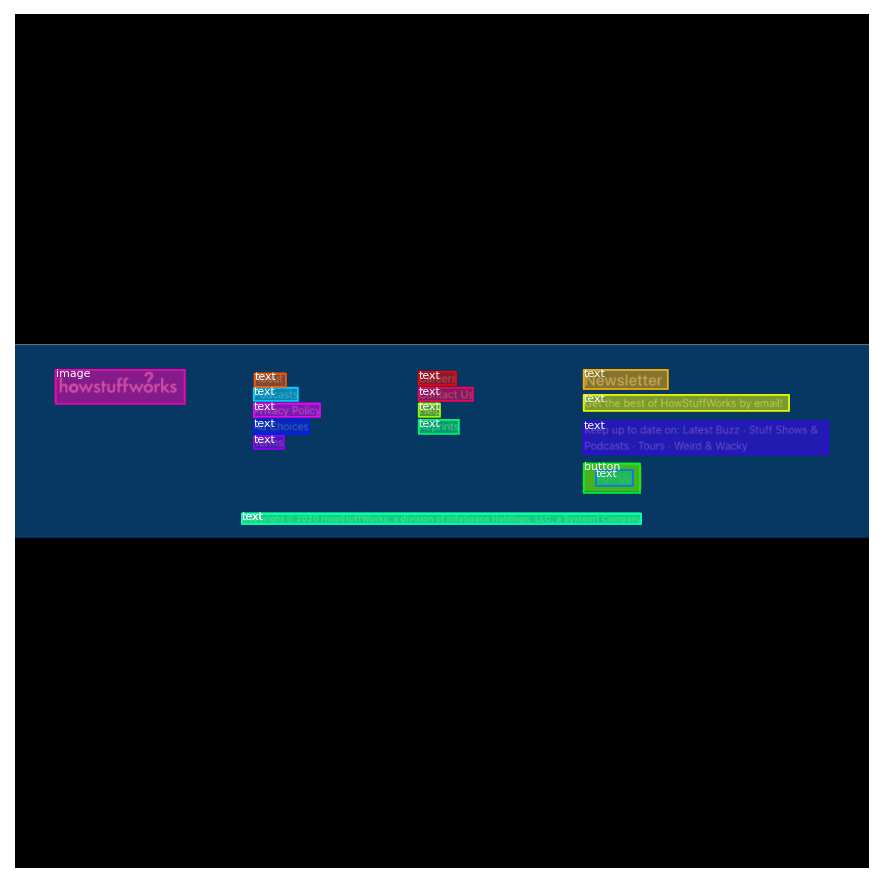

In [46]:
# Load random image and mask.
image_id = np.random.choice(dataset.image_ids, 1)[0]
image = dataset.load_image(image_id)
mask, class_ids = dataset.load_mask(image_id)
original_shape = image.shape
# Resize
image, window, scale, padding, _ = utils.resize_image(
    image, 
    min_dim=config.IMAGE_MIN_DIM, 
    max_dim=config.IMAGE_MAX_DIM,
    mode=config.IMAGE_RESIZE_MODE)
mask = utils.resize_mask(mask, scale, padding)
# Compute Bounding box
bbox = utils.extract_bboxes(mask)

# Display image and additional stats
print("image_id: ", image_id, dataset.image_reference(image_id))
print("Original shape: ", original_shape)
log("image", image)
log("mask", mask)
log("class_ids", class_ids)
log("bbox", bbox)
# Display image and instances
visualize.display_instances(image, bbox, mask, class_ids, dataset.class_names)

image                    shape: (1024, 1024, 3)       min:    0.00000  max:  255.00000  uint8
image_meta               shape: (20,)                 min:    0.00000  max: 1280.00000  float64
class_ids                shape: (26,)                 min:    3.00000  max:    4.00000  int32
bbox                     shape: (26, 4)               min:   86.00000  max:  601.00000  int32
mask                     shape: (1024, 1024, 26)      min:    0.00000  max:    1.00000  bool


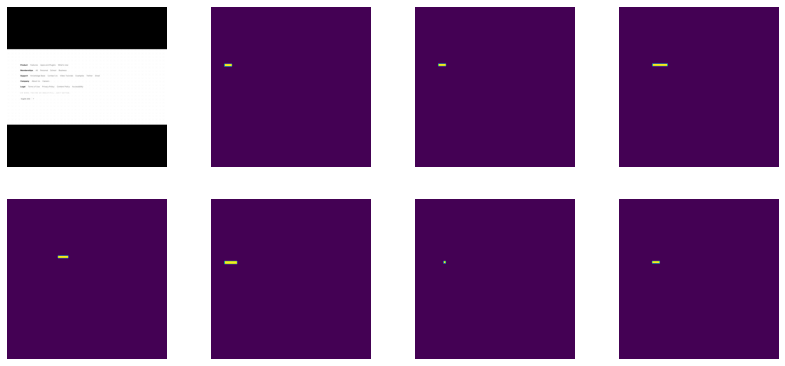

In [47]:
image_id = np.random.choice(dataset.image_ids, 1)[0]
image, image_meta, class_ids, bbox, mask = modellib.load_image_gt(
    dataset, config, image_id, use_mini_mask=False)

log("image", image)
log("image_meta", image_meta)
log("class_ids", class_ids)
log("bbox", bbox)
log("mask", mask)

display_images([image]+[mask[:,:,i] for i in range(min(mask.shape[-1], 7))])

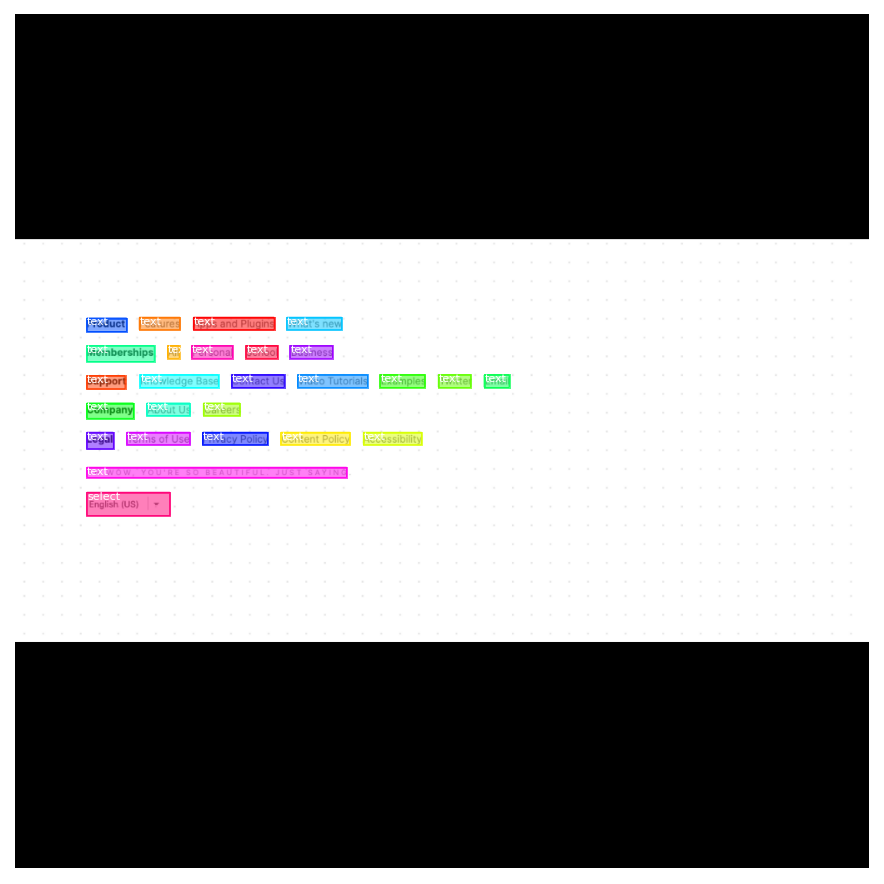

In [48]:
visualize.display_instances(image, bbox, mask, class_ids, dataset.class_names)

mask                     shape: (56, 56, 26)          min:    1.00000  max:    1.00000  bool


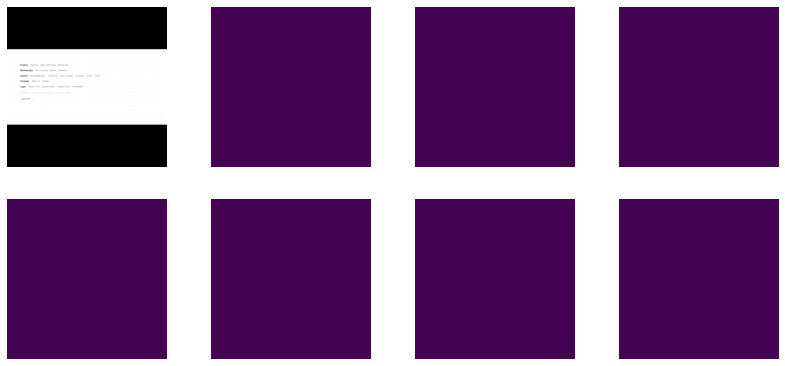

In [49]:
# Add augmentation and mask resizing.
image, image_meta, class_ids, bbox, mask = modellib.load_image_gt(
    dataset, config, image_id, augment=True, use_mini_mask=True)
log("mask", mask)
display_images([image]+[mask[:,:,i] for i in range(min(mask.shape[-1], 7))])

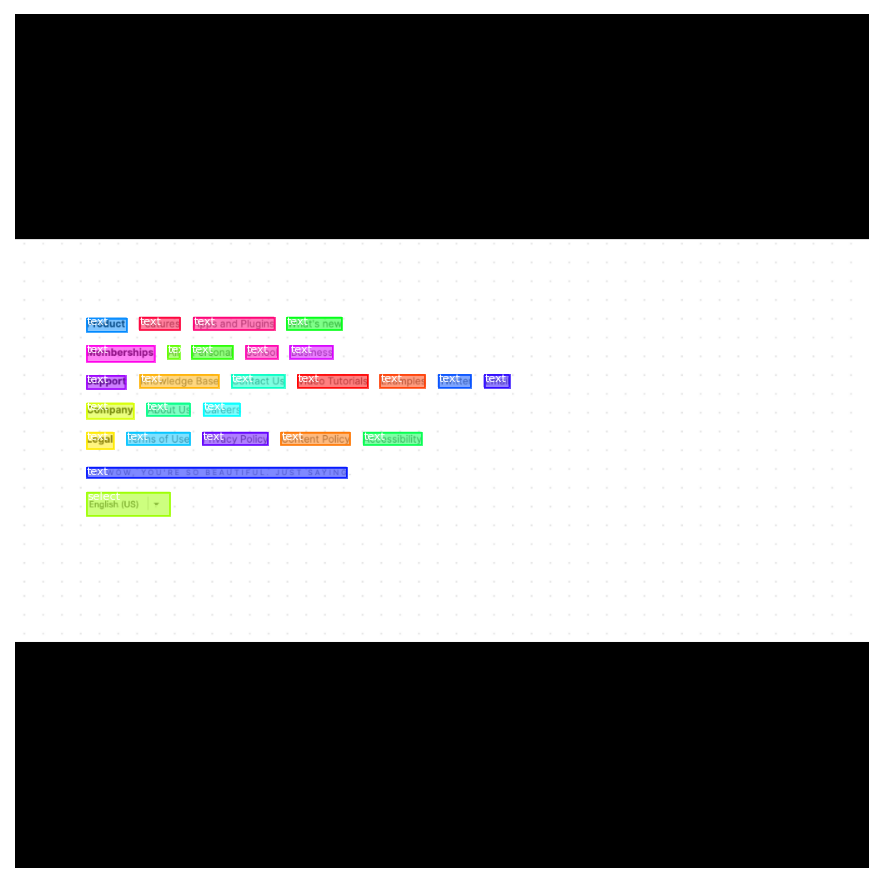

In [50]:
mask = utils.expand_mask(bbox, mask, image.shape)
visualize.display_instances(image, bbox, mask, class_ids, dataset.class_names)

In [51]:
import os
import sys
import random
import math
import re
import time
import numpy as np
import tensorflow as tf
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as patches

# Root directory of the project
ROOT_DIR = os.path.abspath("../../")

# Import Mask RCNN
sys.path.append(ROOT_DIR)  # To find local version of the library
from mrcnn import utils
from mrcnn import visualize
from mrcnn.visualize import display_images
import mrcnn.model as modellib
from mrcnn.model import log

from mrcnn import footer

%matplotlib inline 

# Directory to save logs and trained model
MODEL_DIR = os.path.join(ROOT_DIR, "logs")

# Path to Ballon trained weights
# You can download this file from the Releases page
# https://github.com/matterport/Mask_RCNN/releases
BALLON_WEIGHTS_PATH = "/content/drive/MyDrive/Mask-RCNN-TF2/logs/mask_rcnn_footer_detector_0025.h5"  # TODO: update this path

In [52]:
# Override the training configurations with a few
# changes for inferencing.
class InferenceConfig(config.__class__):
    # Run detection on one image at a time
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

config = InferenceConfig()
config.display()


Configurations:
BACKBONE                       resnet101
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     1
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.75
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 1
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  1024
IMAGE_META_SIZE                20
IMAGE_MIN_DIM                  800
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [1024 1024    3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE        

In [57]:
# Device to load the neural network on.
# Useful if you're training a model on the same 
# machine, in which case use CPU and leave the
# GPU for training.
DEVICE = "/cpu:0"  # /cpu:0 or /gpu:0

# Inspect the model in training or inference modes
# values: 'inference' or 'training'
# TODO: code for 'training' test mode not ready yet
TEST_MODE = "inference"

In [54]:
def get_ax(rows=1, cols=1, size=16):
    """Return a Matplotlib Axes array to be used in
    all visualizations in the notebook. Provide a
    central point to control graph sizes.
    
    Adjust the size attribute to control how big to render images
    """
    _, ax = plt.subplots(rows, cols, figsize=(size*cols, size*rows))
    return ax

In [55]:
# Load validation dataset
dataset = footer.Footer_detectorDataset()
dataset.load_footer_detector(FOOTER_DIR, "val")

# Must call before using the dataset
dataset.prepare()

print("Images: {}\nClasses: {}".format(len(dataset.image_ids), dataset.class_names))

manual annotation class count: 7
annotations count:	60
Images: 60
Classes: ['BG', 'input', 'button', 'text', 'select', 'checkbox', 'radiobutton', 'image']


In [58]:
# Create model in inference mode
with tf.device(DEVICE):
    model = modellib.MaskRCNN(mode="inference", model_dir=MODEL_DIR,
                              config=config)

In [60]:
# Set path to balloon weights file

# Download file from the Releases page and set its path
# https://github.com/matterport/Mask_RCNN/releases
# weights_path = "/path/to/mask_rcnn_balloon.h5"

# Or, load the last model you trained
weights_path = '/content/drive/MyDrive/Mask-RCNN-TF2/logs/mask_rcnn_footer_detector_0025.h5'

# Load weights
print("Loading weights ", weights_path)
model.load_weights(weights_path, by_name=True)

Loading weights  /content/drive/MyDrive/Mask-RCNN-TF2/logs/mask_rcnn_footer_detector_0025.h5


In [ ]:
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np
%matplotlib notebook
from sklearn import svm, metrics, datasets
from sklearn.utils import Bunch
from sklearn.model_selection import GridSearchCV, train_test_split

from skimage.io import imread
from skimage.transform import resize

files = []
image_dir = '/content/drive/MyDrive/Mask-RCNN-TF2/datasets/test'
result_dir = '/content/drive/MyDrive/Mask-RCNN-TF2/results/test'
if not os.path.isdir(result_dir):
    print('creating new result dir')
    os.mkdir(result_dir)
for f in os.listdir(image_dir):
    if f.lower().endswith('.png') or f.lower().endswith('.jpg'):
        files.append(f)
files_to_detect = files
for i, file_name in enumerate(files_to_detect):
    # file_name = random.choice(files)
    # file_name = 'sharpthings_io_users_sign_in_1.png'
    print('{}\t{}'.format(i, file_name))
    image = imread(os.path.join(image_dir, file_name))
    image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)

    # If grayscale, convert to RGB for consistency.
    if image.ndim != 3:
        image = cv2.cvtColor(image, cv2.COLOR_GRAY2BGR)
    # If has an alpha channel, remove it for consistency
    if image.shape[-1] == 4:
        image = image[..., :3]
    # Run object detection
    results = model.detect([image], verbose=0)
    # Display results
    r = results[0]
    new_image = visualize.display_instances(image, r['rois'], r['masks'], r['class_ids'], 
                                dataset.class_names, r['scores'],
                                title="Predictions", show_mask=False)
    # cv2_imshow(new_image)
    # cv2.imwrite(os.path.join(result_dir, file_name), new_image)

image ID: footer_detector.4282_trezor_io_281.png (19) /content/drive/MyDrive/Mask-RCNN-TF2/datasets/footer/val/4282_trezor_io_281.png
Processing 1 images
image                    shape: (1024, 1024, 3)       min:    0.00000  max:  250.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  146.10000  float64
image_metas              shape: (1, 20)               min:    0.00000  max: 1024.00000  int64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


<IPython.core.display.Javascript object>

gt_class_id              shape: (23,)                 min:    3.00000  max:    7.00000  int32
gt_bbox                  shape: (23, 4)               min:   56.00000  max:  968.00000  int32
gt_mask                  shape: (1024, 1024, 23)      min:    0.00000  max:    1.00000  bool


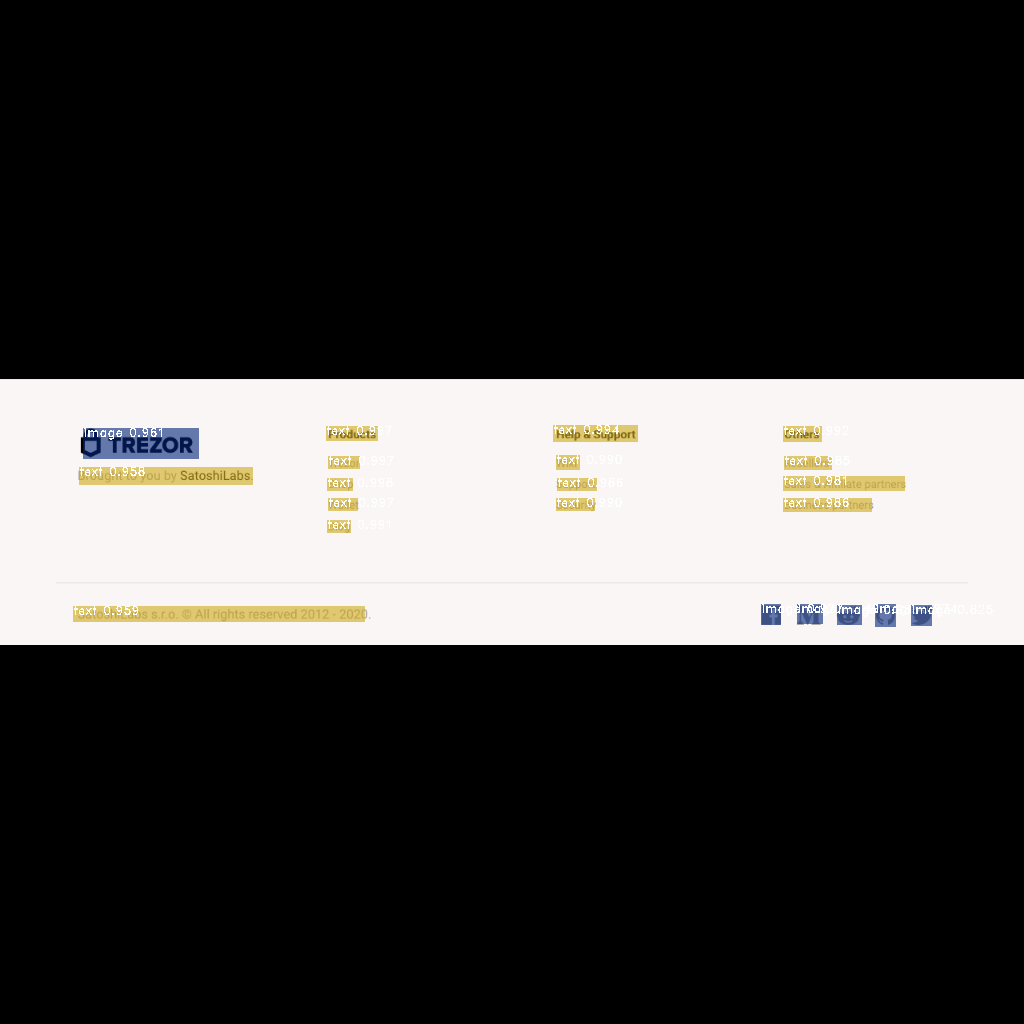

image ID: footer_detector.4291_imamuseum_org_290.png (26) /content/drive/MyDrive/Mask-RCNN-TF2/datasets/footer/val/4291_imamuseum_org_290.png
Processing 1 images
image                    shape: (1024, 1024, 3)       min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 20)               min:    0.00000  max: 1024.00000  int64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


<IPython.core.display.Javascript object>

gt_class_id              shape: (50,)                 min:    3.00000  max:    7.00000  int32
gt_bbox                  shape: (50, 4)               min:   22.00000  max: 1002.00000  int32
gt_mask                  shape: (1024, 1024, 50)      min:    0.00000  max:    1.00000  bool


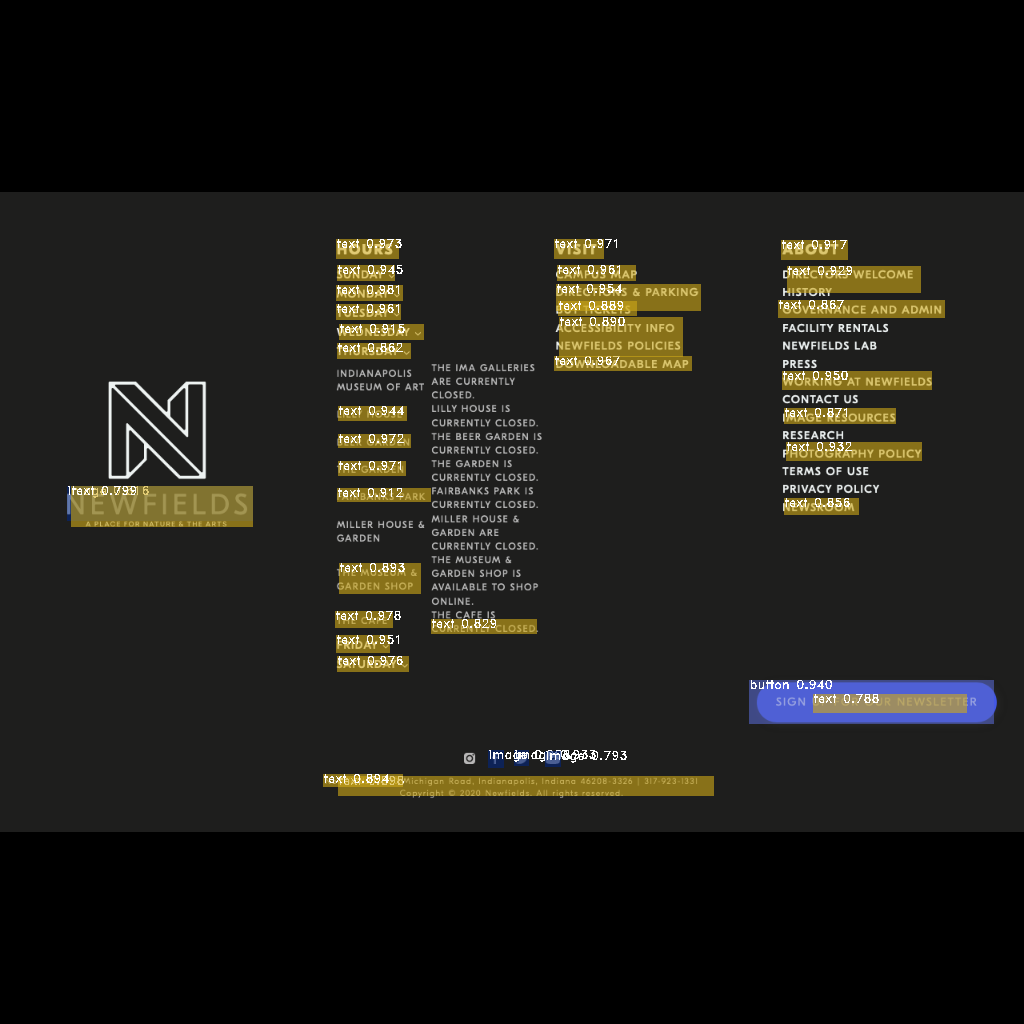

image ID: footer_detector.4304_discoverylife_com_302.png (37) /content/drive/MyDrive/Mask-RCNN-TF2/datasets/footer/val/4304_discoverylife_com_302.png
Processing 1 images
image                    shape: (1024, 1024, 3)       min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 20)               min:    0.00000  max: 1024.00000  int64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


<IPython.core.display.Javascript object>

gt_class_id              shape: (35,)                 min:    1.00000  max:    7.00000  int32
gt_bbox                  shape: (35, 4)               min:   32.00000  max: 1013.00000  int32
gt_mask                  shape: (1024, 1024, 35)      min:    0.00000  max:    1.00000  bool


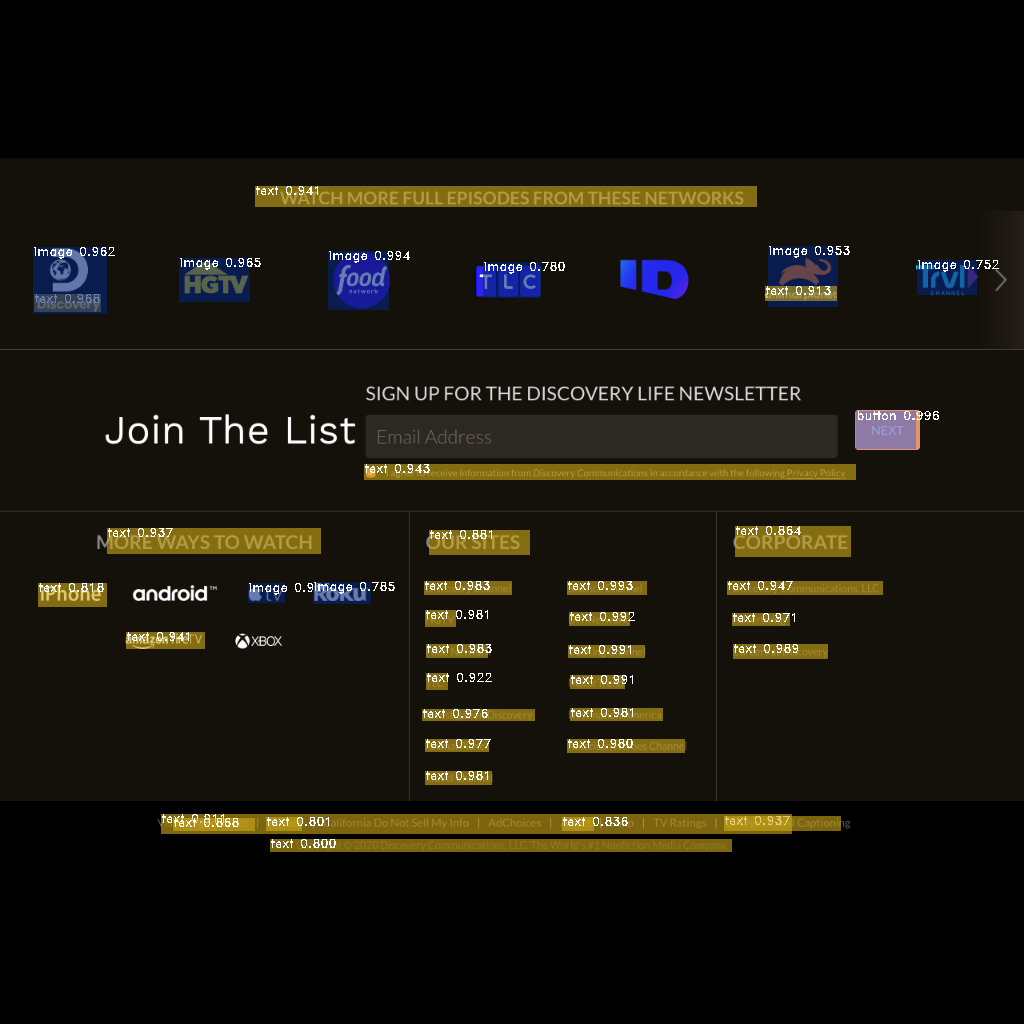

image ID: footer_detector.4297_wetanz_com_295.png (30) /content/drive/MyDrive/Mask-RCNN-TF2/datasets/footer/val/4297_wetanz_com_295.png
Processing 1 images
image                    shape: (1024, 1024, 3)       min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 20)               min:    0.00000  max: 1024.00000  int64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


<IPython.core.display.Javascript object>

gt_class_id              shape: (15,)                 min:    1.00000  max:    7.00000  int32
gt_bbox                  shape: (15, 4)               min:   17.00000  max:  991.00000  int32
gt_mask                  shape: (1024, 1024, 15)      min:    0.00000  max:    1.00000  bool


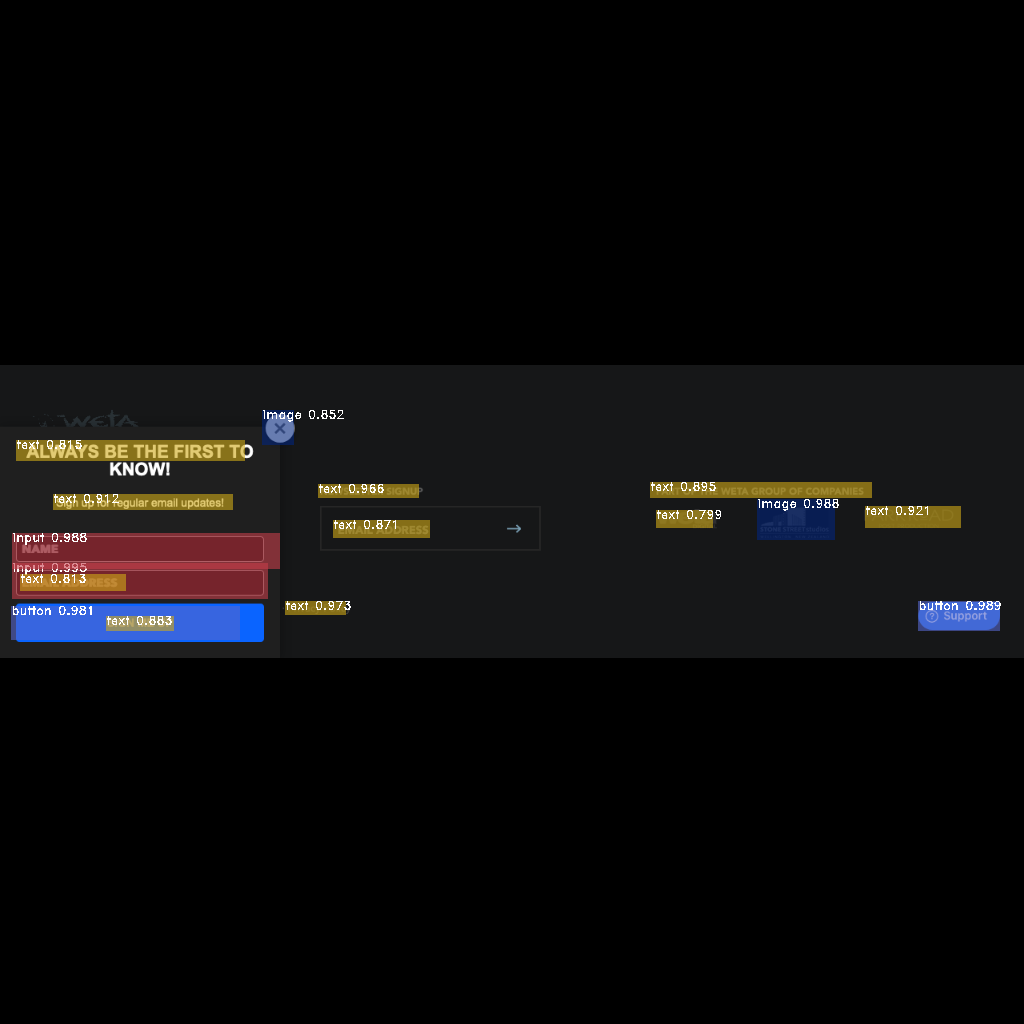

image ID: footer_detector.4264_13newsnow_com_263.png (1) /content/drive/MyDrive/Mask-RCNN-TF2/datasets/footer/val/4264_13newsnow_com_263.png
Processing 1 images
image                    shape: (1024, 1024, 3)       min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 20)               min:    0.00000  max: 1024.00000  int64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


<IPython.core.display.Javascript object>

gt_class_id              shape: (10,)                 min:    3.00000  max:    7.00000  int32
gt_bbox                  shape: (10, 4)               min:  245.00000  max:  864.00000  int32
gt_mask                  shape: (1024, 1024, 10)      min:    0.00000  max:    1.00000  bool


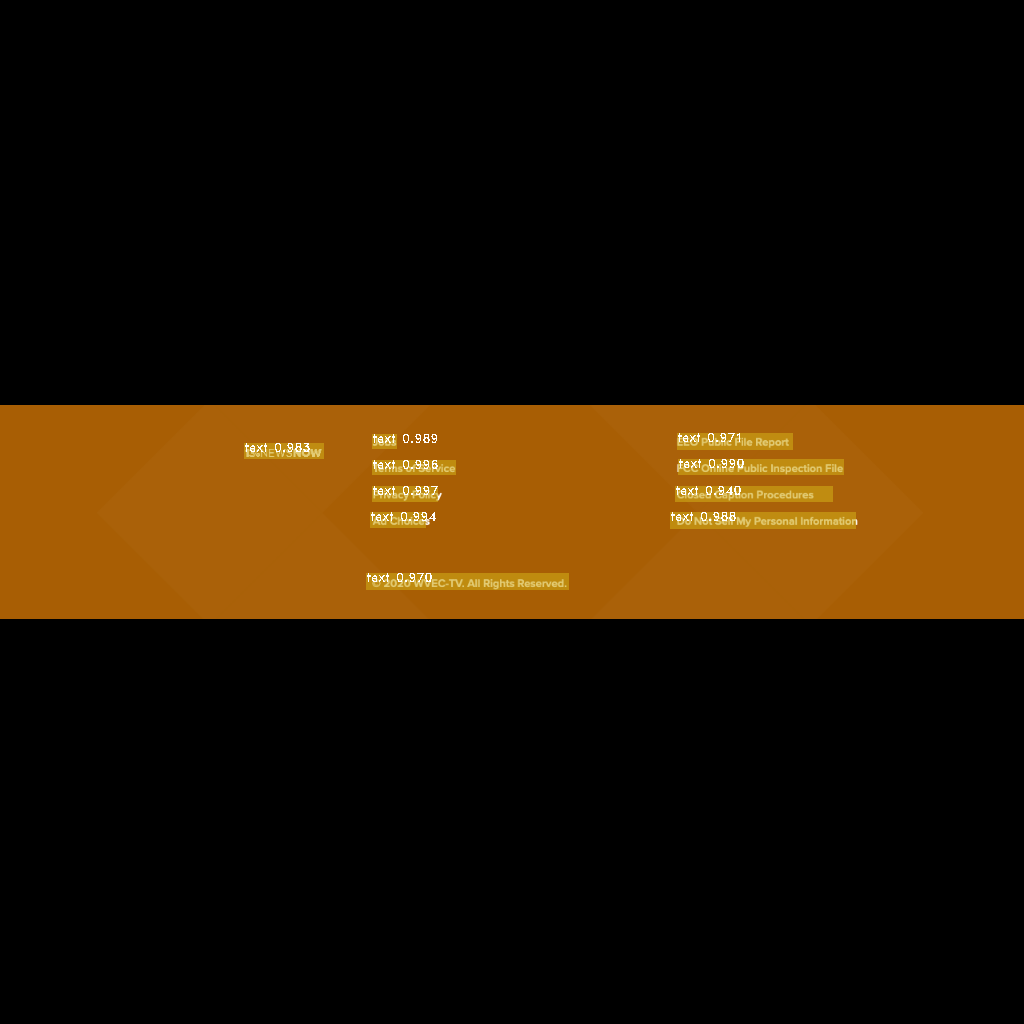

image ID: footer_detector.4316_extremenetworks_com_314.png (48) /content/drive/MyDrive/Mask-RCNN-TF2/datasets/footer/val/4316_extremenetworks_com_314.png
Processing 1 images
image                    shape: (1024, 1024, 3)       min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 20)               min:    0.00000  max: 1024.00000  int64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


<IPython.core.display.Javascript object>

gt_class_id              shape: (39,)                 min:    3.00000  max:    7.00000  int32
gt_bbox                  shape: (39, 4)               min:   57.00000  max:  997.00000  int32
gt_mask                  shape: (1024, 1024, 39)      min:    0.00000  max:    1.00000  bool


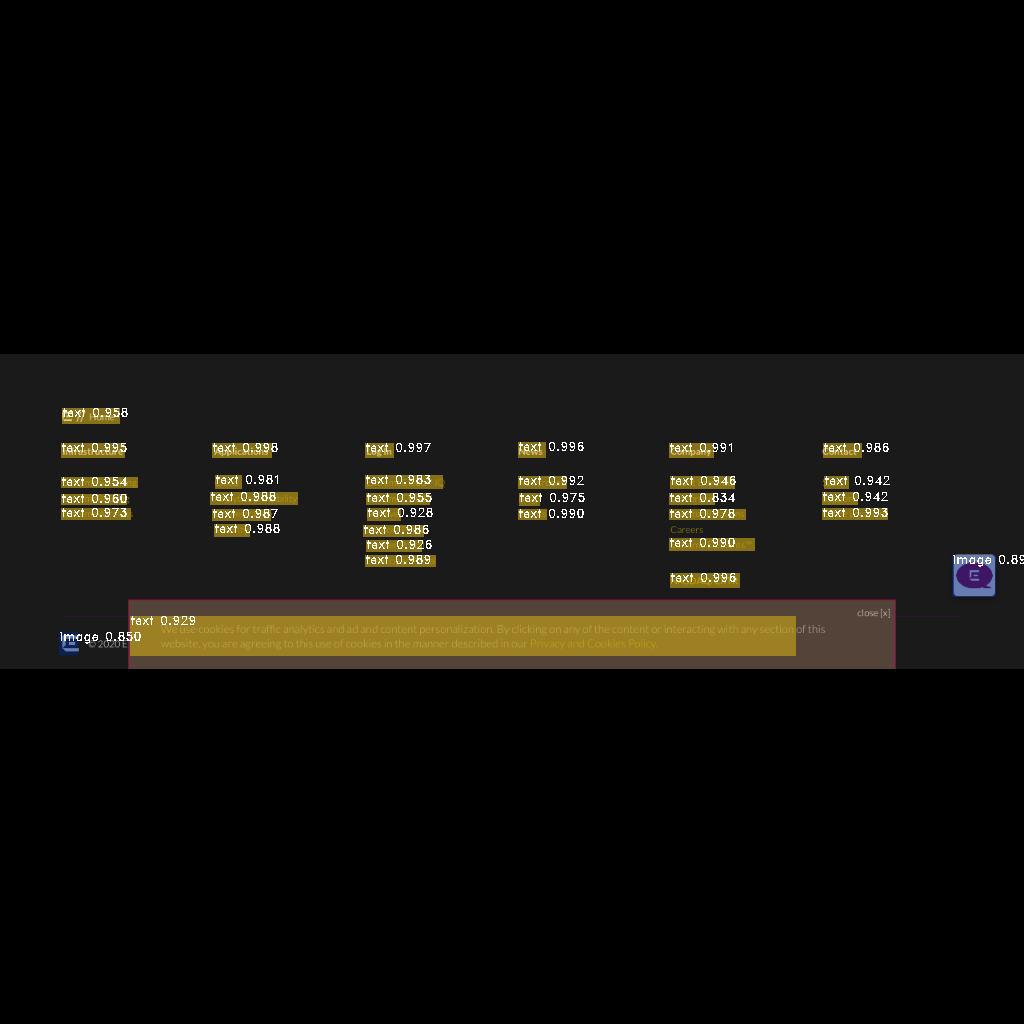

image ID: footer_detector.4298_killedbygoogle_com_296.png (31) /content/drive/MyDrive/Mask-RCNN-TF2/datasets/footer/val/4298_killedbygoogle_com_296.png
Processing 1 images
image                    shape: (1024, 1024, 3)       min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 20)               min:    0.00000  max: 1024.00000  int64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


<IPython.core.display.Javascript object>

gt_class_id              shape: (9,)                  min:    3.00000  max:    7.00000  int32
gt_bbox                  shape: (9, 4)                min:  269.00000  max: 1008.00000  int32
gt_mask                  shape: (1024, 1024, 9)       min:    0.00000  max:    1.00000  bool


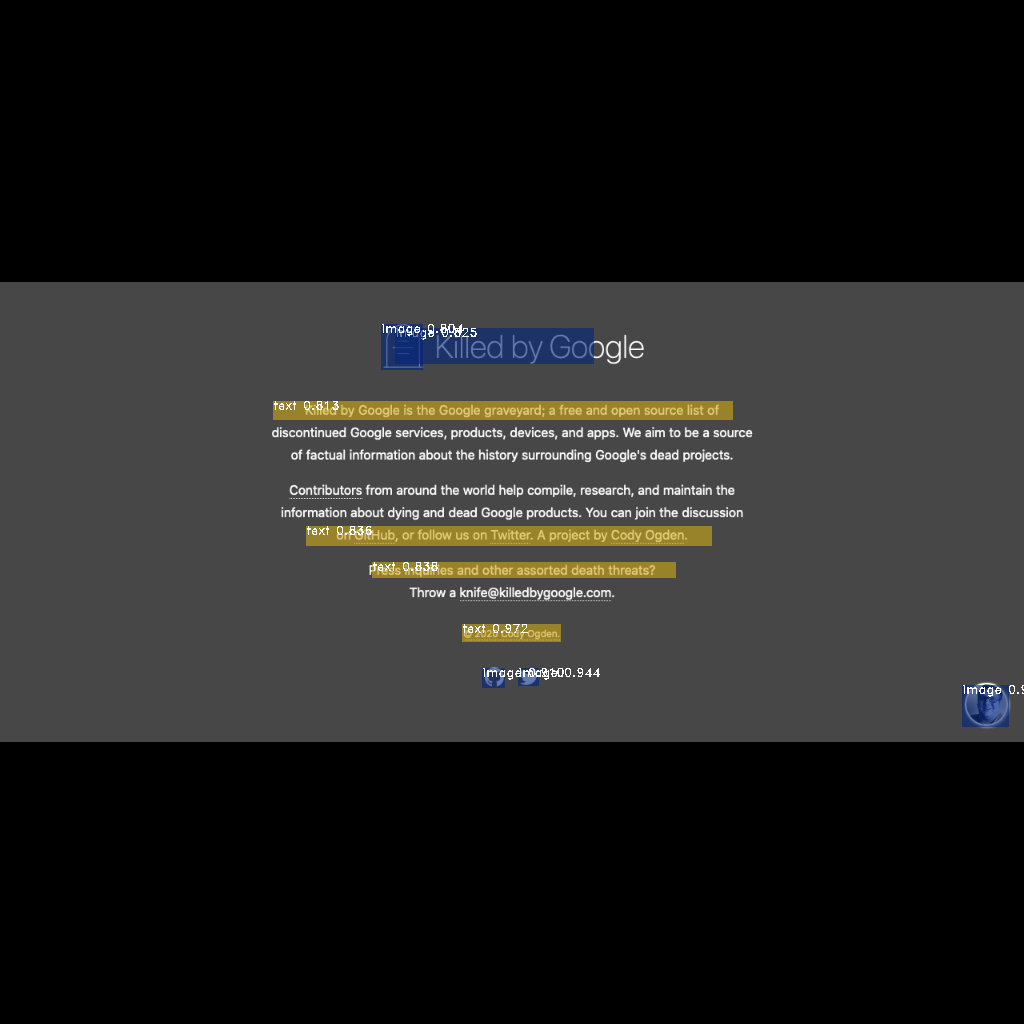

image ID: footer_detector.4313_fontfabric_com_311.png (45) /content/drive/MyDrive/Mask-RCNN-TF2/datasets/footer/val/4313_fontfabric_com_311.png
Processing 1 images
image                    shape: (1024, 1024, 3)       min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 20)               min:    0.00000  max: 1024.00000  int64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


<IPython.core.display.Javascript object>

gt_class_id              shape: (23,)                 min:    1.00000  max:    7.00000  int32
gt_bbox                  shape: (23, 4)               min:   32.00000  max:  977.00000  int32
gt_mask                  shape: (1024, 1024, 23)      min:    0.00000  max:    1.00000  bool


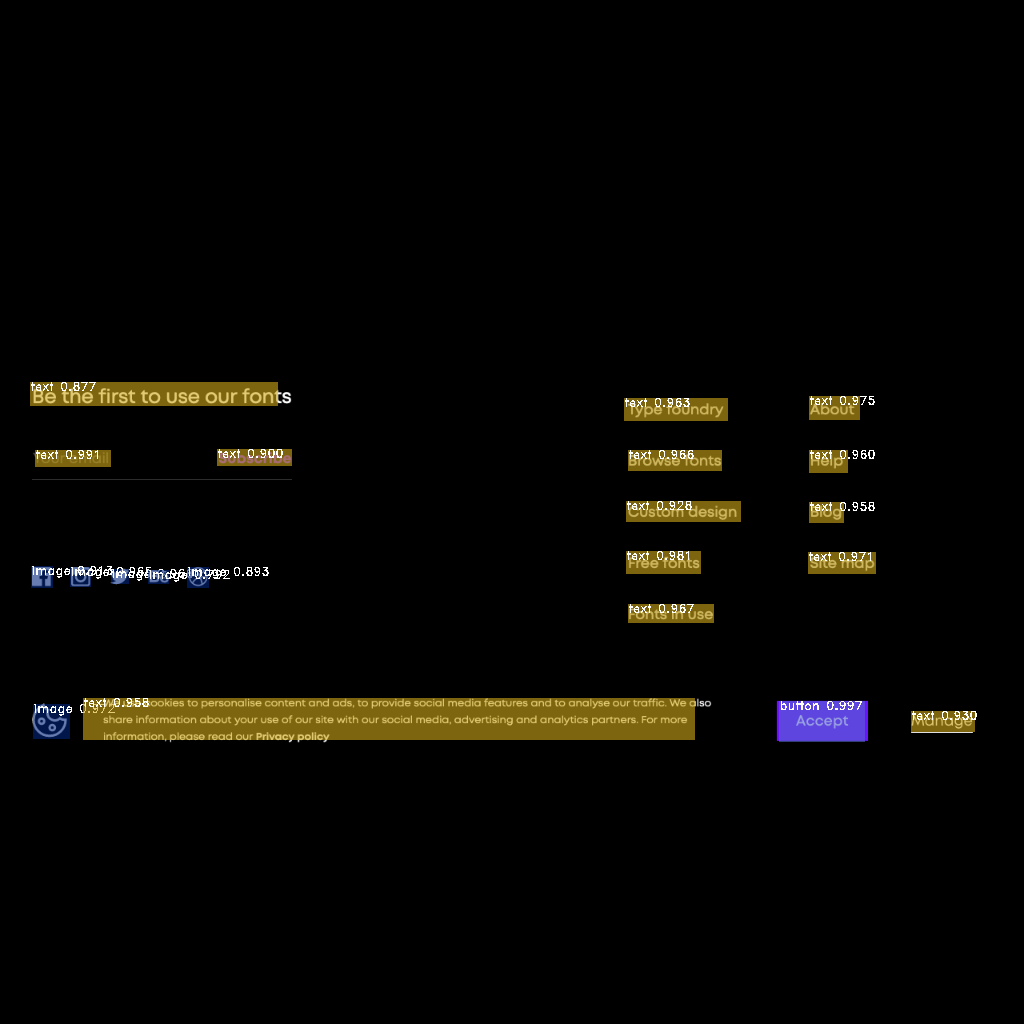

In [97]:
from matplotlib import patches,  lines
from matplotlib.patches import Polygon
import matplotlib.pyplot as plt
from skimage.measure import find_contours
import cv2
from google.colab.patches import cv2_imshow


def display_instances(image, boxes, masks, class_ids, class_names,
                      scores=None, title="",
                      figsize=(10, 10), ax=None,
                      show_mask=True, show_bbox=True,
                      colors=None, captions=None):
    """
    boxes: [num_instance, (y1, x1, y2, x2, class_id)] in image coordinates.
    masks: [height, width, num_instances]
    class_ids: [num_instances]
    class_names: list of class names of the dataset
    scores: (optional) confidence scores for each box
    title: (optional) Figure title
    show_mask, show_bbox: To show masks and bounding boxes or not
    figsize: (optional) the size of the image
    colors: (optional) An array or colors to use with each object
    captions: (optional) A list of strings to use as captions for each object
    """
    # Number of instances
    N = boxes.shape[0]
    if not N:
        print("\n*** No instances to display *** \n")
    else:
        assert boxes.shape[0] == masks.shape[-1] == class_ids.shape[0]

    colors = [
        (191, 97, 194),
        (71, 59, 195),
        (201, 100, 84),
        (21, 167, 205),
        (137, 139, 81),
        (188, 169, 171),
        (94, 134, 0),
        (122, 35, 0),
        (0, 76, 153),
    ]

    new_img = image.copy()
    for i in range(N):
        class_id = class_ids[i]
        color = colors[class_id]
        # Bounding box
        if not np.any(boxes[i]):
            continue
        y1, x1, y2, x2 = boxes[i]
        if show_bbox:
            rect = new_img[y1:y2, x1:x2]
            color_rect = np.ones(rect.shape, np.uint8)
            color_rect[:] = color
            result = cv2.addWeighted(rect, 0.4, color_rect, 0.6, 1.0)
            new_img[y1:y2, x1:x2] = result

        # Label
        if not captions:
            class_id = class_ids[i]
            score = scores[i] if scores is not None else None
            label = class_names[class_id]
            caption = "{} {:.3f}".format(label, score) if score else label
        else:
            caption = captions[i]
        cv2.putText(new_img, caption, (x1, y1 + 8), cv2.FONT_HERSHEY_DUPLEX,0.4,(255, 255, 255))
    return new_img

files = []
image_dir = '/content/drive/MyDrive/Mask-RCNN-TF2/datasets/test'
result_dir = '/content/drive/MyDrive/Mask-RCNN-TF2/results/test'
if not os.path.isdir(result_dir):
    print('creating new result dir')
    os.mkdir(result_dir)
for f in os.listdir(image_dir):
    if f.lower().endswith('.png') or f.lower().endswith('.jpg'):
        files.append(f)
files_to_detect = files
for i, file_name in enumerate(files_to_detect):
    image_id = random.choice(dataset.image_ids)
    image, image_meta, gt_class_id, gt_bbox, gt_mask =\
        modellib.load_image_gt(dataset, config, image_id, use_mini_mask=False)
    info = dataset.image_info[image_id]
    print("image ID: {}.{} ({}) {}".format(info["source"], info["id"], image_id, 
                                          dataset.image_reference(image_id)))

    # Run object detection
    results = model.detect([image], verbose=1)

    # Display results
    ax = get_ax(1)
    r = results[0]
    
    new_image = display_instances(image, r['rois'], r['masks'], r['class_ids'], 
                                dataset.class_names, r['scores'], ax=ax,
                                title="Predictions")
    log("gt_class_id", gt_class_id)
    log("gt_bbox", gt_bbox)
    log("gt_mask", gt_mask)

    cv2_imshow(new_image)